## Cell 1: Import Libraries

In [1]:
# Health Insurance Cost Estimator
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

## Cell 2: Load and Explore Data


In [2]:
# Load the dataset
df = pd.read_excel('insurance_data_6000.xlsx', sheet_name='Sheet1')

# Data Exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())

FileNotFoundError: [Errno 2] No such file or directory: 'insurance_data_6000.xlsx'

## Cell 3: Data Visualization


NameError: name 'df' is not defined

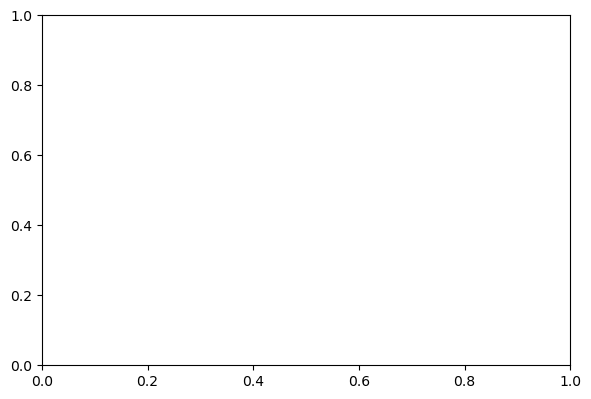

In [3]:
# Visualizations
plt.figure(figsize=(15, 10))

# Distribution of Annual Premium
plt.subplot(2, 2, 1)
sns.histplot(df['Annual_Premium_Amount'], kde=True)
plt.title('Distribution of Annual Premium Amount')

# Premium by Insurance Plan
plt.subplot(2, 2, 2)
sns.boxplot(x='Insurance_Plan', y='Annual_Premium_Amount', data=df)
plt.title('Premium by Insurance Plan')

# Premium by Age
plt.subplot(2, 2, 3)
sns.scatterplot(x='Age', y='Annual_Premium_Amount', data=df)
plt.title('Premium by Age')

# Premium by BMI Category
plt.subplot(2, 2, 4)
sns.boxplot(x='BMI_Category', y='Annual_Premium_Amount', data=df)
plt.title('Premium by BMI Category')

plt.tight_layout()
plt.show()

## Cell 4: Feature Engineering

In [ ]:
# Feature Engineering
# Create a feature for number of medical conditions
df['Num_Medical_Conditions'] = df['Medical_History'].apply(lambda x: 0 if x == 'No Disease' else len(x.split(',')))

# Convert income levels to numerical values (midpoint of each range)
income_mapping = {
    '<10L': 5,
    '10L-25L': 17.5,
    '25L-40L': 32.5,
    '>40L': 50  # Assuming average above 40L is 50 for simplicity
}
df['Income_Numerical'] = df['Income_Level'].map(income_mapping)

## Cell 5: Data Preprocessing

In [ ]:
# Data Preprocessing
# Define features and target
X = df.drop(['Annual_Premium_Amount', 'Income_Lakhs', 'Income_Level'], axis=1)
y = df['Annual_Premium_Amount']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical_features = ['Gender', 'Region', 'Marital_status', 'BMI_Category', 
                       'Smoking_Status', 'Employment_Status', 'Insurance_Plan', 'Medical_History']
numerical_features = ['Age', 'Number_Of_Dependants', 'Num_Medical_Conditions', 'Income_Numerical']

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

## Cell 6: Model Building and Evaluation

In [ ]:
# Model Building
# Define models to test
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'SVR': SVR()
}

# Evaluate each model
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'R2 Score': r2
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2 Score: {r2:.2f}")
    print()

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.sort_values('R2 Score', ascending=False))

## Cell 7: Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning for the best model (XGBoost in this case)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print("\nFinal Model Performance:")
print(f"RMSE: {final_rmse:.2f}")
print(f"R2 Score: {final_r2:.2f}")

## Cell 8: Feature Importance

In [ ]:
# Feature Importance
# Get feature names after one-hot encoding
preprocessor.fit(X_train)
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Get feature importances from the best model
importances = best_model.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()

## Cell 9: Save Model and Prediction Function

In [ ]:
# Save the model
joblib.dump(best_model, 'health_insurance_cost_estimator.pkl')

# Create a prediction function for demonstration
def predict_insurance_cost(age, gender, region, marital_status, num_dependants, 
                          bmi_category, smoking_status, employment_status, 
                          income_level, medical_history, insurance_plan):
    # Create a DataFrame from the input
    input_data = pd.DataFrame({
        'Age': [age],
        'Gender': [gender],
        'Region': [region],
        'Marital_status': [marital_status],
        'Number_Of_Dependants': [num_dependants],
        'BMI_Category': [bmi_category],
        'Smoking_Status': [smoking_status],
        'Employment_Status': [employment_status],
        'Medical_History': [medical_history],
        'Insurance_Plan': [insurance_plan],
        'Num_Medical_Conditions': [0 if medical_history == 'No Disease' else len(medical_history.split(','))],
        'Income_Numerical': [income_mapping.get(income_level, 50)]  # Default to 50 if not found
    })
    
    # Load the saved model
    model = joblib.load('health_insurance_cost_estimator.pkl')
    
    # Make prediction
    prediction = model.predict(input_data)
    
    return prediction[0]

# Example prediction
example_prediction = predict_insurance_cost(
    age=45,
    gender='Male',
    region='Northeast',
    marital_status='Married',
    num_dependants=2,
    bmi_category='Overweight',
    smoking_status='No Smoking',
    employment_status='Salaried',
    income_level='25L-40L',
    medical_history='High blood pressure',
    insurance_plan='Gold'
)

print(f"\nExample Prediction: ₹{example_prediction:.2f}")